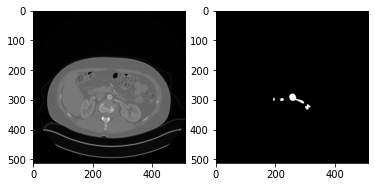

In [16]:
from utils.convert import Convert
from utils.visualization import show_views

# raw image root
convert_file = Convert()
image_root = "/public/datasets/kidney/kits21/kits21/data/case_00000/imaging.nii.gz"
# xcd fix
patient_name = ""
images_numpy = convert_file.select(image_root)
mask_root = "/public/home/cxiao/Study/data/artery/predict/nodule2021-07-11 15:37:24.nii"
mask_numpy = convert_file.select(mask_root).transpose((2,1,0))
index =192

show_views(images_numpy[index],mask_numpy[index],cmap="gray")

In [1]:
import SimpleITK as sitk
import os
from utils.config import config
images = sitk.ReadImage(os.path.join(config.kits_image_root, "0", "case_00004.nii.gz"))
result = sitk.GetImageFromArray(images)
print(result.shape)

RuntimeError: Exception thrown in SimpleITK new_Image: /tmp/SimpleITK/Code/Common/src/sitkImageExplicit.cxx:62:
sitk::ERROR: Unsupported number of dimesions specified by size: [ 8388608 ]!
The maximum supported Image dimension is 5.